In [1]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#gsm modes
# process_gen_mode="llama_gsm_sample"
# compare_metric='final_num_exact_match'


#wmt modes
# process_gen_mode="wmt_samples"
# process_gen_mode="wmt_beam8"
# compare_metric="example_comet"

process_gen_mode="wmt_beam128"
compare_metric="BLEU_4"

#instruct modes
# process_gen_mode="instruct8"
# compare_metric="example_themis"




do_norm_analysis=True
processGens.init_with_mode(process_gen_mode)


root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics = processGens.get_params()

examples_df, completions_df=get_dfs(processGens, num_beams_list)


if(do_norm_analysis):
    for col in [compare_metric, 'output_logprob']:
        examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )

dfs_by_model={}
for model_idx, model_name in enumerate(models):
    filtered_df = examples_df[examples_df["model"]==model_idx]
    dfs_by_model[model_name]=filtered_df


all_dfs_by_model=dfs_by_model
if(len(models)>1):
    all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode wmt_beam128
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['beam_num', 'task_name', 'model', 'example_idx', 'text',
       'completion_length', 'output_logprob', 'instanceID', 'isCompletion',
       'BLEU_1', 'BLEU_4', 'comet'],
      dtype='object')
Num examples: 128000
Num completions: 1000


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [128] 
 	 models: ['meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name sample_1_eval_1000 
 	 instance_metrics ['comet']
   beam_num  task_name  model  example_idx  \
0       128          0      0            0   
1       128          0      0            1   

                                                text  completion_length  \
0  He advised the parents of a boy whose penis ha...                174   
1  He advised the parents of a boy whose penis ha...                178   

   output_logprob instanceID isCompletion    BLEU_1    BLEU_4     comet  \
0      -25.499082    id24245         True  0.736842  0.485714  0.879338   
1      -25.547711    id24245         None  0.710526  0.371429       NaN   

   BLEU_4_norm  output_logprob_norm  
0     0.888570             2.390407  
1    -0.531413             2.323874  
num examples 128000
num_comp

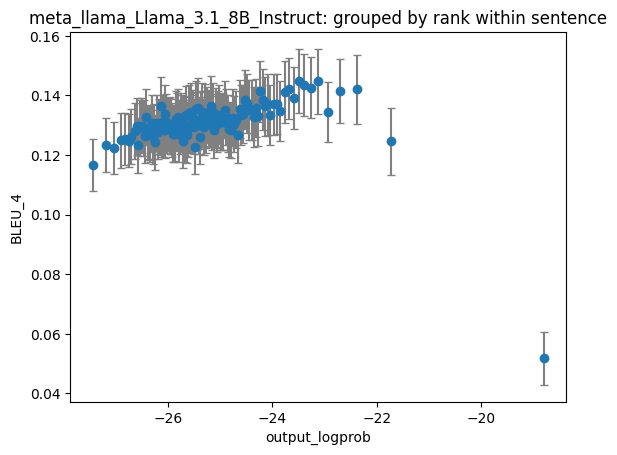

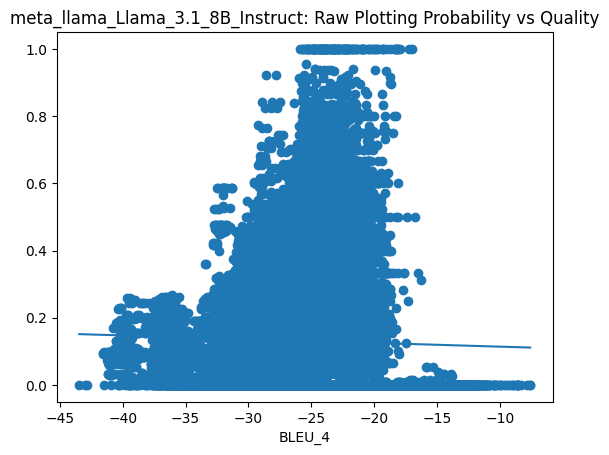

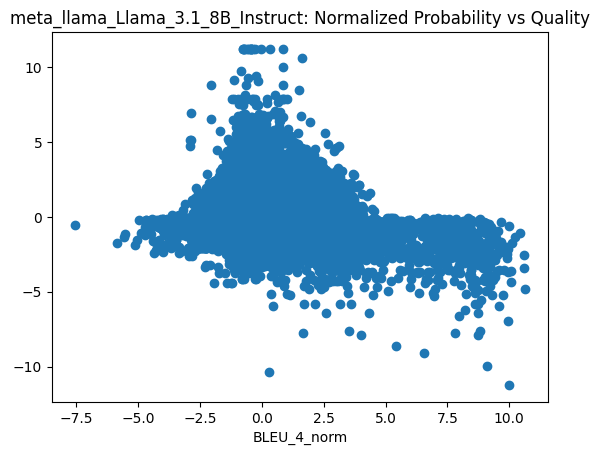

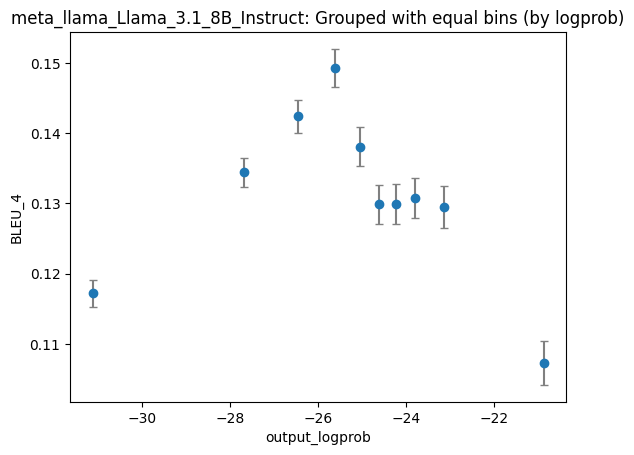

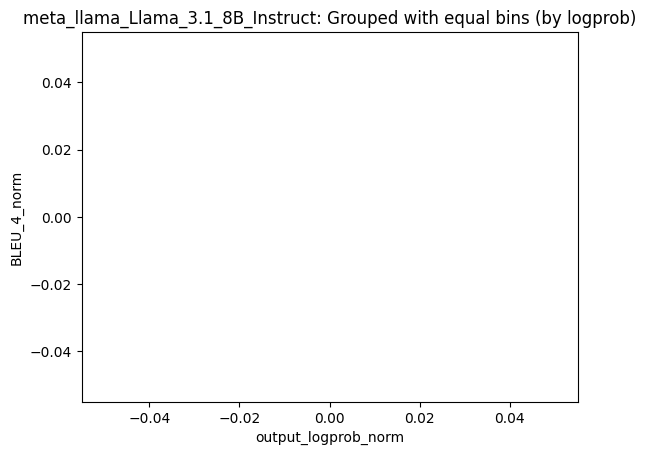

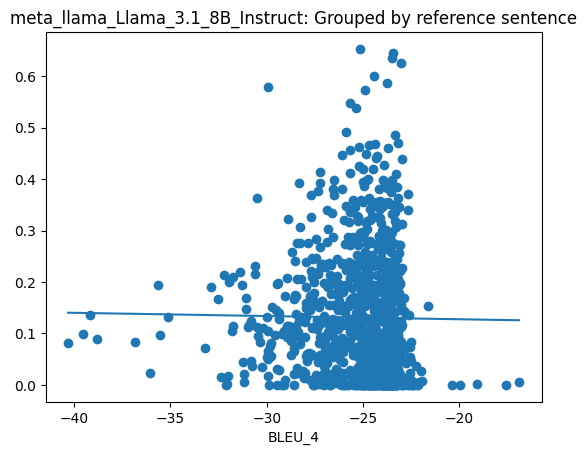

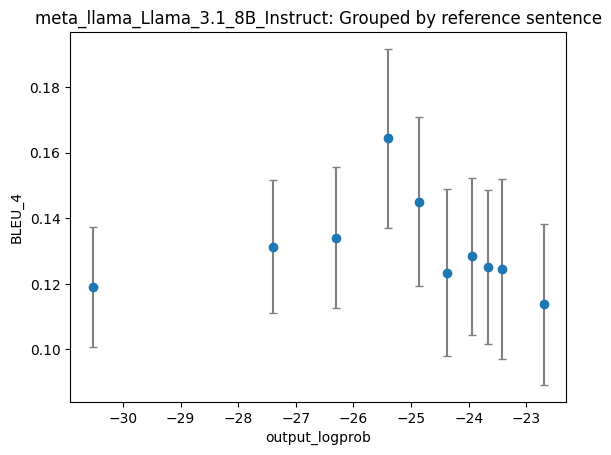

In [3]:

plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None
# fig, axs = plt.subplots(plots_wide, plots_tall, figsize=(8, 8))


for idx, (model_name, filtered_dfs) in enumerate(dfs_by_model.items()):
    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs

    
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    # plot by rank within sentence
    suptitle="grouped by rank within sentence"
    plot_grouped(df=filtered_df, xlabel="output_logprob", ylabel=compare_metric, title=calculate_title(), ax=ax)
    

    # plot 
    
    suptitle="Raw Plotting Probability vs Quality"
    plot_keys(df=examples_df, xlabel='output_logprob', ylabel=compare_metric, title=calculate_title(), ax=ax)


    # just plot metric / probability (normalized) 
    suptitle="Normalized Probability vs Quality"
    plot_keys(df=filtered_df, xlabel='output_logprob_norm', ylabel=compare_metric+'_norm', title=calculate_title(), ax=ax)

    # plot: group into equally-sized bins (ignores examples example_id)
    suptitle="Grouped with equal bins (by logprob)"
    plot_grouped(df=filtered_dfs, xlabel="output_logprob", groupby="bins", ylabel=compare_metric, title=calculate_title(), ax=ax, nbins=10)

    suptitle="Grouped with equal bins (by logprob)"
    plot_grouped(df=filtered_df, xlabel='output_logprob_norm',  groupby="bins", ylabel=compare_metric+'_norm', title=calculate_title(), ax=ax, nbins=10)

    # suptitle="Grouped by reference sentence"
    instance_df=filtered_df.groupby("instanceID")[["output_logprob", compare_metric]].mean()
    suptitle="Grouped by reference sentence"
    plot_keys(df=instance_df, xlabel='output_logprob', ylabel=compare_metric, title=calculate_title(), ax=ax)
    
    suptitle="Grouped by reference sentence"
    plot_grouped(df=instance_df, xlabel='output_logprob',  groupby="bins", ylabel=compare_metric, title=calculate_title(), ax=ax, nbins=10)
    
if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    